# Кейс №2 - Приложение доставки

## Описание задачи

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

*Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.*

В данных вы найдете логи заказов пользователей:

ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

ab_products – подробная информация о продуктах, их название и стоимость

## Загрузка данных и библиотек

In [1]:
# избавляемся от ворнингов о том, что используются старые версии пакетов
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import pandas as pd
import ast
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# stats
# from scipy import stats
import scipy.stats as stats
import pingouin as pg

### Преобразование данных, объединение в одну таблицу + краткий EDA

Для начала, я скачаю все данные, немного почищу, и соединю их всех в одну табличку

In [3]:
ab_users_data = pd.read_csv('ab_users_data.csv')

ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [4]:
ab_users_data.shape

(4337, 6)

In [5]:
ab_users_data.isnull().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [6]:
ab_orders = pd.read_csv('ab_orders.csv')

ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [7]:
ab_orders.shape

(4123, 3)

In [8]:
ab_orders.isnull().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [9]:
# Преобразуем строковые представления словарей в списки
ab_orders['product_ids'] = ab_orders.product_ids.apply(lambda x: x.strip('{}').split(', '))

ab_orders.product_ids.head()

0    [75, 22, 53, 84]
1        [56, 76, 39]
2    [76, 34, 41, 38]
3             [74, 6]
4    [20, 45, 67, 26]
Name: product_ids, dtype: object

In [10]:
# Разделяем каждый список на отдельные строки и расширяем таблицу + дропаем индексы и переименовываем столбец 
ab_orders = ab_orders.explode('product_ids') \
    .reset_index(drop = True) \
    .rename(columns = {'product_ids': 'product_id'}) 

ab_orders.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
1,1255,2022-08-26 00:00:19.000000,22
2,1255,2022-08-26 00:00:19.000000,53
3,1255,2022-08-26 00:00:19.000000,84
4,1256,2022-08-26 00:02:21.000000,56


In [11]:
ab_orders['product_id'] = ab_orders.product_id.apply(lambda x: int(x))

In [12]:
ab_orders.shape

(13826, 3)

In [13]:
ab_products = pd.read_csv('ab_products.csv')

ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [14]:
ab_products.shape

(87, 3)

In [15]:
ab_products.isnull().sum()

product_id    0
name          0
price         0
dtype: int64

Нулей нет ни в одной таблице, все таблицы приведены к адекватному виду. Джойним!

In [16]:
df = ab_users_data.merge(ab_orders, how = 'right', on = 'order_id')
df = df.merge(ab_products, how = 'left', on = 'product_id')

df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56,сосиски,150.0


In [17]:
# удаляем creation_time который по сути копия time
df = df.drop('creation_time', axis = 1)

In [18]:
df.shape

(14569, 9)

In [19]:
df.dtypes

user_id         int64
order_id        int64
action         object
time           object
date           object
group           int64
product_id      int64
name           object
price         float64
dtype: object

## Формулирование метрик

Мне сразу же приходят в голову две метрики - стоимость одного заказа, и стоимость всех заказов одним клиентом. Если стоимость всех заказов одним клиентом возрастет, то выгода для бизнеса будет очевидна. Но если только стоимость одного заказа повысится, а общая сумма всех заказов - нет, то и выгоды особой не будет.

Поэтому основной метрикой будет средняя стоимость всех заказов одним клиентом, а прокси - средняя стоимость одного заказа

### Расчет метрик 

In [20]:
# конкретно чтобы получить эту таблицу с order_price user_id не нужен. Но я хочу сделать дальнейшую группировку по юзеру

user_order_price = df \
    .groupby(['user_id', 'order_id'], as_index = False) \
    .agg({'price': 'sum'}) \
    .rename(columns = {'price': 'order_price'})

user_order_price.head()

,user_id,order_id,order_price
0,964,1255,408.7
1,964,1257,310.2
2,965,1256,250.5
3,965,3946,860.6
4,965,9097,608.2


In [21]:
# считаем сумму покупок для каждого юзера

user_price = user_order_price \
    .groupby('user_id', as_index = False) \
    .agg({'order_price': 'sum'}) \
    .rename(columns = {'order_price': 'user_sum'})

user_price.head()

,user_id,user_sum
0,964,718.9
1,965,4155.5
2,966,170.0
3,967,1137.4
4,968,1590.7


In [22]:
# присоединяем все метрики к оригинальному датасету

df = df.merge(user_order_price, how = 'left', on = ['user_id', 'order_id'])
df = df.merge(user_price, how = 'left', on = 'user_id')

df.head()

,user_id,order_id,action,time,date,group,product_id,name,price,order_price,user_sum
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,75,сок ананасовый,120.0,408.7,718.9
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,22,сок мультифрукт,120.0,408.7,718.9
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,53,мука,78.3,408.7,718.9
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,84,мандарины,90.4,408.7,718.9
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,56,сосиски,150.0,250.5,4155.5


## Базовое сравнение получившихся метрик в тестовой и контрольной группе

Давайте посмотрим, насколько отличается количество заказов и людей в обоих группах тестирования

In [23]:
df.query('group == 0').order_id.nunique()

1609

In [24]:
df.query('group == 1').order_id.nunique() 

2514

In [25]:
df.query('group == 0').user_id.nunique() 

515

In [26]:
df.query('group == 1').user_id.nunique() 

502

В то время, как количество пользователей приблизительно одинаковое, количество заказов разительно отличается. В группе с рекомендацией товаров люди заказали больше заказов, что может сказаться на общей выручке в положительную сторону

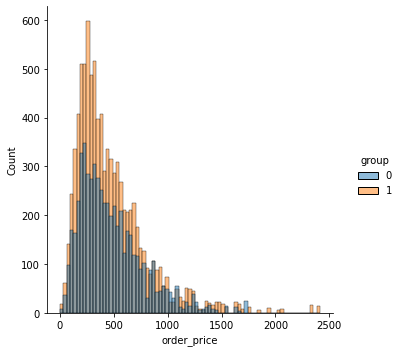

In [27]:
sns.displot(data = df, x = 'order_price', hue = 'group')

Можем заметить, что особых отличий (видимых) по цене заказа - нет

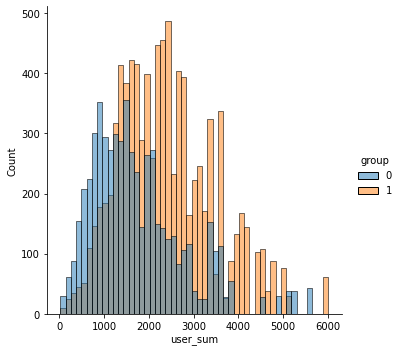

In [28]:
sns.displot(data = df, x = 'user_sum', hue = 'group')

В то время как по количеству денег, принесенных пользователями, лидирует тестовая группа.

## Сравнение средней стоимости всех заказов одним клиентом

Давайте посчитаем, отличается ли средняя сумма выручки от пользователей по группам в эксперименте:

In [29]:
test = df.loc[df.group == 0, 'user_sum']
control = df.loc[df.group == 1, 'user_sum']

print(test.head(), control.head())

0    718.9
1    718.9
2    718.9
3    718.9
7    718.9
Name: user_sum, dtype: float64 4     4155.5
5     4155.5
6     4155.5
15    1137.4
16    1137.4
Name: user_sum, dtype: float64


### Стат. тесты

Проверим assumption 

Нулевая гипотеза - распределены нормально
Альтернативная гипотеза - не нормально

In [30]:
stats.normaltest(test)

NormaltestResult(statistic=1068.2328520177718, pvalue=1.0868847380157286e-232)

In [31]:
stats.normaltest(control)

NormaltestResult(statistic=469.68488548327207, pvalue=1.0214638482031612e-102)

In [32]:
print(test.std().round(2), control.std().round(2))
# большие стандартные отклонения. В целом, выбросы можно найти на графиках выше - они и влияют на ненормальность распределения

1063.87 1072.54


pvalue в обоих случаях меньше 0.05 => отклоняем нулевую гипотезу => распределения не нормальные

Доверяю цифрам, провожу непараметрический тест Манна-Уитней, и следом тест Стьюдента просто на проверку: если они оба покажут одинаковый стат. значимый результат, можно будет говорить о том, что именно средние отличаются, а не "ранки"

In [33]:
stats.mannwhitneyu(test, control)

MannwhitneyuResult(statistic=15830934.5, pvalue=0.0)

In [34]:
stats.ttest_ind(test, control)

Ttest_indResult(statistic=-35.444947615102734, pvalue=4.866962538630725e-264)

In [35]:
round((test.mean() - control.mean()), 2)

-643.81

Разница средних значений составляет аж 643 доллара

Оба теста показывают показывают pvalue < 0.05 (да и даже меньше 0.01, но мы решили, что порог значимости именно 0.05). 

Значит, мы отклоняем нулевую гипотезу о равенстве средних и говорим, что основываясь на предоставленных данных, средняя сумма принесенная одним покупателем действительно отличается в контрольной и тестовой группе

## Сравнение средней стоимости одного заказа

Проверим, верно ли это также для средней суммы заказа!

In [36]:
test = df.loc[df.group == 0, 'order_price']
control = df.loc[df.group == 1, 'order_price']

print(test.head(), control.head())

0    408.7
1    408.7
2    408.7
3    408.7
7    310.2
Name: order_price, dtype: float64 4     250.5
5     250.5
6     250.5
15    228.0
16    228.0
Name: order_price, dtype: float64


### Стат. тесты

Проверим assumption 

Нулевая гипотеза - распределены нормально
Альтернативная гипотеза - не нормально

In [37]:
stats.normaltest(test)

NormaltestResult(statistic=1177.3627877767362, pvalue=2.1823230268886542e-256)

In [38]:
stats.normaltest(control)

NormaltestResult(statistic=3466.137266807192, pvalue=0.0)

In [39]:
print(test.std().round(2), control.std().round(2))
# большие стандартные отклонения. В целом, выбросы можно найти на графиках выше - они и влияют на ненормальность распределения

300.8 333.72


pvalue в обоих случаях меньше 0.05 => отклоняем нулевую гипотезу => распределения не нормальные

Доверяю цифрам, провожу непараметрический тест Манна-Уитней, и следом тест Стьюдента просто на проверку: если они оба покажут одинаковый стат. значимый результат, можно будет говорить о том, что именно средние отличаются, а не "ранки"

In [40]:
stats.mannwhitneyu(test, control)

MannwhitneyuResult(statistic=25975331.5, pvalue=0.0029738569283321746)

In [41]:
stats.ttest_ind(test, control)

Ttest_indResult(statistic=0.39986432136151795, pvalue=0.6892623152169639)

Итак, ттест и манн-уитней показывают разные значения: согласно первому тесту, есть основание отклонить нулевую гипотезу о равенстве средних, в то время как согласно второму - нет. Чтобы не делать выводы в рамках абстрактных "рангах" (согласно Анатолию), я сделаю бутстреп и сравню, пересекаются ли доверительный интервал средних

In [42]:
pg.compute_bootci(test, func='mean', seed=123)

array([468.58, 483.96])

In [43]:
pg.compute_bootci(control, func='mean', seed=123)

array([467.02, 480.82])

Как видим, доверительные интервалы средних пересекаются, а значит, статистически значимого отличия в полученных оценках параметра нет =(

Происходит интересная ситуация - манн-уитней говорит о том, что стат. значимы различия между переменными есть, а остальные стат. методы - нет. Честно говоря, с таким я сталкиваюсь в первый раз

In [44]:
round((test.mean() - control.mean()), 2)

2.18

Среднее различие действительно не особо выросло. Но что касается медианных? Может быть, тут будет какое-то различие? Не даром же Манн-Уитней показал стат. значимые различия

In [45]:
round((np.median(test) - np.median(control)), 2)

23.75

А вот здесь разница уже хорошая, целых 23.75 доллара. Проверим с помощью бутстрепа:

In [46]:
pg.compute_bootci(test, func = np.median, seed=123)

array([396. , 419.5])

In [47]:
pg.compute_bootci(control, func = np.median, seed=123)

array([374.3, 390.9])

Супер! Дов. интервалы не пересекаются, следовательно, различия оказались стат. значимы

## Выводы

Что-ж, перехожу к финальным выводам. 

Не знаю, насколько сильно новая система рекомендаций принесла пользу пользователям приложениям, но что касается бизнеса, результат очевиден: пользователи с новой системой рекомендацией в среднем оставляли чек на 600 долларов больше, чем такие же пользователи со старой версией приложения. Это статистически значимая разница, а не рандомная флуктуация данных: это я доказал с помощью теста Манна-Уитней и теста Стьюдента.

Что касается средней суммы одного заказа, статистической связи найти не удалось - опираясь и на тест Стьюдента, и на бутстреп средних отвергнуть нулевую гипотезе о равенстве средних не получилось - да и оно действительно не особо выросло (2.18 доллара). Однако, т.к. Манн-Уитней показал статистически значимые различия между двумя выборками, я решил запустить бутстреп, проверяющий дов. интервал медиан. С 95% вероятностью, дов. интервалы медиан тестовой и контрольной группы НЕ пересекались, а соответственно, значимая разница между медианами была обнаружена. Разница между медианным чеком за заказ в контрольной и тестовой группе оказалась равна 23.75, и она стат. значимая. 

Итого, **новая рекомендательная система** улучшила обе наши метрики, прямо ведущие к повышению оборота компании, а следовательно, **я считаю, что ее можно "раскатывать" на всех юзеров**